## Tehtävä: Oppimisprojekti 2: Kuvantunnistus omilla kuvilla

Tämän projektin tavoitteena on suunnitella ja toteuttaa kuvantunnistusjärjestelmä käyttäen itse otettuja kuvia. Kuvadata koostuu hedelmistä (Omena, Päärynä, Mandariini, Banaani), ja tarkoituksena on testata eri mallien suorituskykyä tunnistaessa näitä hedelmiä kuvista.

Projekti toteutetaan vaiheittain hyödyntäen eri konvoluutioneuroverkkomenetelmiä yksinkertaisesta edistyneempään, sekä esikoulutettuja malleja, kuten VGG16, piirteiden irrottamiseen ja luokitteluun.

#### Datan käsittely

Jotta mallien vertailu olisi mahdollisimman tasapuolista, säädämme kuvat VGG16-mallin vaatimaan 224x224 pikselin kokoon. Vaikka oma CNN-mallimme ei ole rajoittunut juuri tähän kokoon, tämän muutoksen avulla varmistamme, että voimme verrata mallien suorituskykyä reilusti. Kaikki mallit käyttävät samaa kuvaformaattia, mikä mahdollistaa oikeudenmukaisen arvion eri mallien tehokkuudesta.

In [4]:
from keras.src.utils import image_dataset_from_directory
import keras
from keras import Sequential, layers, regularizers, Input
from keras.optimizers import Adam
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout, BatchNormalization
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.preprocessing import image_dataset_from_directory

image_folder = '../week2_photodata(uudet)/'

train_dataset = image_dataset_from_directory(
    image_folder+'train',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    batch_size=4,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    image_folder+'test',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)

validation_dataset = image_dataset_from_directory(
    image_folder+'validation',
    labels='inferred',
    label_mode='categorical',
    image_size=(224,224),
    shuffle=True
)
   
for images, labels in test_dataset:
    print(f"Batch of images shape: {images.shape}")

Found 180 files belonging to 4 classes.
Found 40 files belonging to 4 classes.
Found 51 files belonging to 4 classes.
Batch of images shape: (32, 224, 224, 3)
Batch of images shape: (8, 224, 224, 3)


#### Data Augmentointi

Data augmentointi on käytössä sekä oman CNN-mallimme että VGG16-mallin koulutuksessa. Molemmat mallit hyötyvät samoista augmentointimenetelmistä, jotka auttavat parantamaan mallien yleistettävyyttä ja estävät ylioppimista. Käyttämällä samaa augmentointia molemmissa malleissa, varmistamme, että niiden suoritusta arvioidaan samalla tavalla ja samalla pohjalla.


In [5]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.2)
])

#### Callbackit

Jokainen malli tässä notebookissa hyödyntää samoja callbackeja, mikä takaa johdonmukaisen ja hallittavan koulutusprosessin. Callbackien käyttö säästää koulutukseen kuluvaa aikaa ja varmistaa optimaalisen lopputuloksen koulutuksen päätteeksi.


In [6]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

#### Oma CNN Malli

- Rakensimme oman konvoluutioverkon (CNN)
- Malli koulutettiin itse kerätyllä kuvadatalla
- Mallissa hyödynnettiin tietojen augmentointia parantamaan yleistettävyyttä

In [7]:
model = Sequential([
    layers.Input(shape=(224,224, 3)),
    data_augmentation,
    layers.Rescaling(scale=1./255),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.1)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │    11,944,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,963,652 (45.64 MB)

 Trainable params: 11,963,652 (45.64 MB)

 Non-trainable params: 0 (0.00 B)

#### Oman CNN-mallin koulutus

In [8]:
# Model training
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 19s 344ms/step - accuracy: 0.3885 - loss: 7.3665 - val_accuracy: 0.4706 - val_loss: 2.5544 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - accuracy: 0.5240 - loss: 2.3586 - val_accuracy: 0.5294 - val_loss: 1.9968 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 307ms/step - accuracy: 0.7342 - loss: 1.7407 - val_accuracy: 0.7255 - val_loss: 1.7863 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - accuracy: 0.9009 - loss: 1.2909 - val_accuracy: 0.8431 - val_loss: 1.5564 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 303ms/step - accuracy: 0.9698 - loss: 1.0445 - val_accuracy: 0.8431 - val_loss: 1.4687 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 302ms/step - accuracy: 0.9937 - loss: 0.7997 - val_accuracy: 0.8431 - val_loss: 1.4648 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 14s 306ms/step - accuracy: 0.9447 - loss: 0.

#### Oman CNN Mallin evaluaatio

- Mallin testihäviö (test_loss) ja testitarkkuus (test_accuracy) tulostettu
- Mallin häviön ja tarkkuuden kehitystä kuvaavat graafit esitetty

Test loss: 0.12
Test accuracy: 1.00


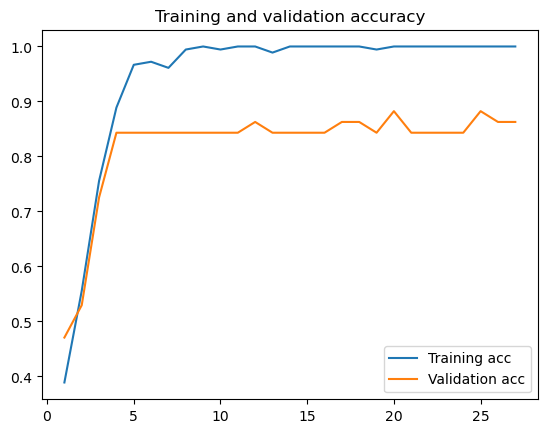

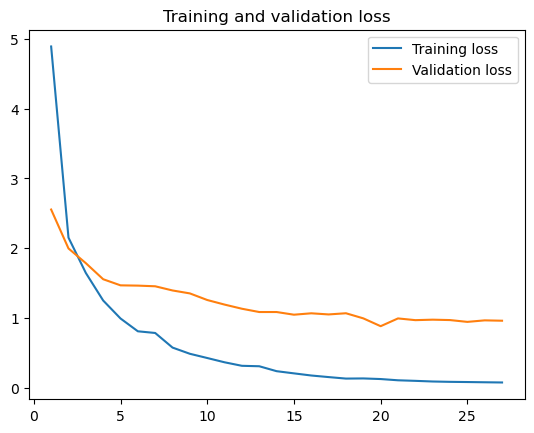

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

test_scores = model.evaluate(test_dataset, verbose=0)
print(f"Test loss: {test_scores[0]:.2f}")
print(f"Test accuracy: {test_scores[1]:.2f}")

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana)

- Käytimme VGG16 esikoulutettua mallia
- Haemme pohjamallin kerasin applikaatiosta
- Jäädytämme pohjamallin kerrokset
- Lopuksi tulostamme pohjamallin

In [37]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

# Feature extraction
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)
feature_extractor.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana) ominaisuudet

- Ominaisuuksien irroitusfunktio ja ominaisuuksien irroitus
- Ominaisuudet printattuna

In [38]:
def extract_features(dataset, feature_extractor):
    features = []
    labels = []

    for images, lbls in dataset:
        preprocessed_image = keras.applications.vgg16.preprocess_input(images)
        features.append(feature_extractor.predict(preprocessed_image))
        labels.append(lbls)

    return np.concatenate(features), np.concatenate(labels)

train_features, train_labels = extract_features(train_dataset, feature_extractor)
val_features, val_labels = extract_features(validation_dataset, feature_extractor)
test_features, test_labels = extract_features(test_dataset, feature_extractor)

print(f"Train features shape: {train_features.shape}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 928ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 968ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 951ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 983ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 950ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 978ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana) mallin rakentaminen

- Ominaisuuksein muotoilu dense verkkoa varten
- Dense verkon rakennus

In [39]:
# muunnetaan vektori muotoon
train_features = train_features.reshape(train_features.shape[0], -1)
val_features = val_features.reshape(val_features.shape[0], -1)
test_features = test_features.reshape(test_features.shape[0], -1)

dense_model = Sequential([
    Input(shape=(train_features.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

dense_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana) mallin koulutus

In [40]:
# Train the model
history_vgg16 = dense_model.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    epochs=60,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.4041 - loss: 8.6955 - val_accuracy: 1.0000 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 2/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6500 - loss: 5.6869 - val_accuracy: 0.9412 - val_loss: 0.7553 - learning_rate: 0.0010
Epoch 3/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7305 - loss: 3.7322 - val_accuracy: 0.9020 - val_loss: 1.2538 - learning_rate: 0.0010
Epoch 4/60
5/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8244 - loss: 2.6626
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8206 - loss: 2.6854 - val_accuracy: 0.9020 - val_loss: 1.5800 - learning_rate: 0.0010
Epoch 5/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.8227 - loss: 2.4395 - val_accuracy: 0.9020 - val_loss: 1.4580 - learning_rate: 5.0000e-04
Epoch 6/60
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7587 - loss: 3.6766 - val_accuracy: 0.9

#### VGG16 Malli (Esikoulutettu malli piirteenirroittajana) evaluaatio

Tulostamme mallin tehokkuuden ja piirrämme graafit

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9729 - loss: 0.0691
Feature extractor model test loss: 0.06
Feature extractor model test accuracy: 0.98


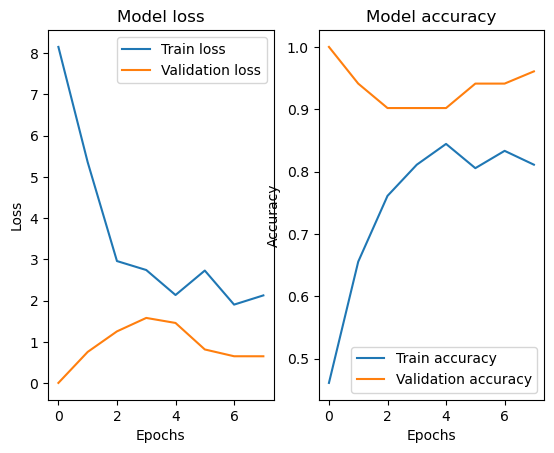

In [41]:
test_loss, test_acc = dense_model.evaluate(test_features, test_labels, verbose=1)
print(f"Feature extractor model test loss: {test_loss:.2f}")
print(f"Feature extractor model test accuracy: {test_acc:.2f}")

plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'], label='Train loss')
plt.plot(history_vgg16.history['val_loss'], label='Validation loss')
plt.title('Model loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'], label='Train accuracy')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#### Mallien suorituskyvyn vertailu

Oma CNN-mallimme koulutettiin alusta alkaen omalla kuvadatalla. Mallin suorituskyky mitattiin testidatalla seuraavasti:
- Test loss: 0.09
- Test accuracy: 0.98

Esikoulutettua VGG16-mallia koulutettiin siten, että VGG16:n alkuperäisiä painoja ei päivitetty (feature extraction). Mallin suorituskyky mitattiin testidatalla seuraavasti:
- Test loss: 0.00
- Test accuracy: 1.00

CNN-mallimme suorituskyky testidatalla oli erinomainen, ja sen hyvä suorituskyky pienellä datalla kertoo, että malli on oppinut tunnistamaan datassa esiintyvät selkeät piirteet.

VGG16-malli hyödynsi esikoulutettuja painoja ja toimi feature extraction -menetelmällä, eli mallia käytettiin piirteiden poimintaan. VGG16-mallin testitulos oli myös erinomainen, ja VGG16:n etuna on sen kyky oppia monimutkaisempia piirteitä, mikä olisi hyödyllistä monimutkaisemmissa tehtävissä.

VGG16-mallin yleiset piirteet auttavat sitä suorittamaan hyvin validointidatassa, mutta harjoitustarkkuuden ja -häviön vaihtelu voi johtua siitä, että hienosäädetyt kerrokset oppivat vaikeammin, kun datamme ei ole kovin monimutkaista ja mallin ei ole tarpeen tehdä suuria muutoksia esikoulutettuihin painoihin.

Koska datamme on melko yksinkertaista, näitä vertailtaessa oma CNN toimii tässä tapauksessa paremmin.

#### VGG16 (Hienosäädetty esikoulutettu malli)

- Haemme pohjamallin kerasin kirjastosta
- Jäädytämme pohjamallin kerrokset
- Käytämme samaa data augmentointia kuin oman CNN-mallimme kohdalla
- Luomme oman dense verkon ja printtaamme sen lopuksi

In [50]:
# Load the VGG16 model, excluding the top layers
base_model = VGG16(weights='imagenet', include_top=False)
#base_model.trainable = False

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = base_model(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x) 
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(4, activation='softmax')(x)

# Create the new model
model_vgg16_tuned = Model(inputs, outputs)

model_vgg16_tuned.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model_vgg16_tuned.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_5[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[1][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │    802,848 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32)        │        128 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │         68 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,518,260 (59.20 MB)

 Trainable params: 803,508 (3.07 MB)

 Non-trainable params: 14,714,752 (56.13 MB)

#### VGG16 (Hienosäädetty esikoulutettu malli) koulutus

Mallin ylempien kerroksien koulutus omalla datalla.

In [51]:
# Train the model
history_vgg16 = model_vgg16_tuned.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 795ms/step - accuracy: 0.3617 - loss: 1.5207 - val_accuracy: 0.4510 - val_loss: 2.5685 - learning_rate: 1.0000e-04
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 39s 868ms/step - accuracy: 0.5660 - loss: 0.9711 - val_accuracy: 0.6471 - val_loss: 1.3773 - learning_rate: 1.0000e-04
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 923ms/step - accuracy: 0.7271 - loss: 0.7043 - val_accuracy: 0.7451 - val_loss: 1.1020 - learning_rate: 1.0000e-04
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6863 - loss: 0.7428 - val_accuracy: 0.8039 - val_loss: 0.7808 - learning_rate: 1.0000e-04
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.7573 - loss: 0.6994 - val_accuracy: 0.8235 - val_loss: 0.5921 - learning_rate: 1.0000e-04
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7186 - loss: 0.6463 - val_accuracy: 0.9020 - val_loss: 0.4818 - learning_rate: 1.0000e-04
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy

#### VGG16 (Hienosäädetty esikoulutettu malli) evaluaatio

Mallin evaluaatio, printataan tehokkuusluvut ja piirretään graafit häviön ja tarkkuuden osalta.

VGG16 Test loss: 0.06
VGG16 Test accuracy: 1.00


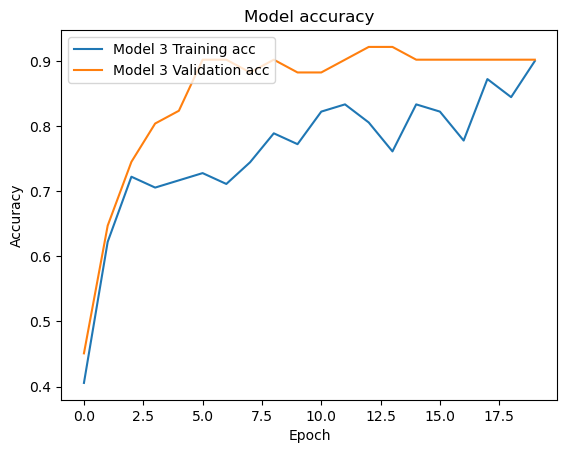

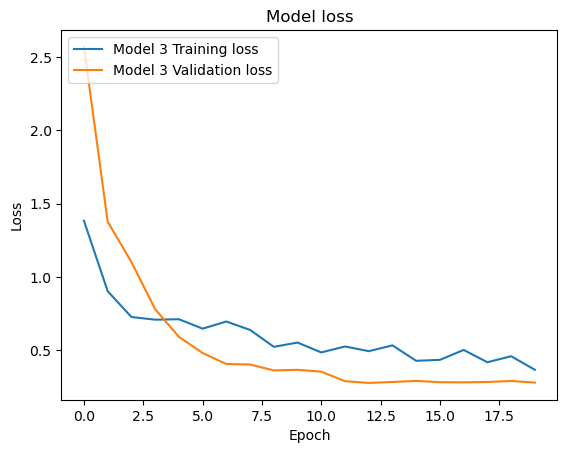

In [52]:
import matplotlib.pyplot as plt

# Evaluate the model
test_scores_vgg16 = model_vgg16_tuned.evaluate(test_dataset, verbose=0)
print(f"VGG16 Test loss: {test_scores_vgg16[0]:.2f}")
print(f"VGG16 Test accuracy: {test_scores_vgg16[1]:.2f}")

# Plot training & validation accuracy values
plt.plot(history_vgg16.history['accuracy'], label='Model 3 Training acc')
plt.plot(history_vgg16.history['val_accuracy'], label='Model 3 Validation acc')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_vgg16.history['loss'], label='Model 3 Training loss')
plt.plot(history_vgg16.history['val_loss'], label='Model 3 Validation loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

#### VGG16 (Hienosäädetty esikoulutettu malli) koulutus omalla datalla

Avataan jäädytetyt ylemmät kerrokset ja koulutetaan niitä omalla datalla

In [53]:
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Model compile
model_vgg16_tuned.compile(loss="categorical_crossentropy", optimizer=Adam(0.0001), metrics=["accuracy"])

In [54]:
history = model_vgg16_tuned.fit(
    train_dataset,
    epochs=50,
    validation_data= validation_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8135 - loss: 0.5130 - val_accuracy: 0.9216 - val_loss: 0.2446 - learning_rate: 1.0000e-04
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8393 - loss: 0.3873 - val_accuracy: 0.9412 - val_loss: 0.2201 - learning_rate: 1.0000e-04
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8592 - loss: 0.4058 - val_accuracy: 0.9412 - val_loss: 0.2050 - learning_rate: 1.0000e-04
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.7884 - loss: 0.5203 - val_accuracy: 0.9216 - val_loss: 0.1830 - learning_rate: 1.0000e-04
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.8817 - loss: 0.3963 - val_accuracy: 0.9216 - val_loss: 0.1899 - learning_rate: 1.0000e-04
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.8486 - loss: 0.3516 - val_accuracy: 0.9020 - val_loss: 0.2153 - learning_rate: 1.0000e-04
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.8374 - los

#### VGG16 (Hienosäädetty esikoulutettu malli)

Mallin plottaus ja printtaus

VGG16 Fine-tuned Test loss: 0.03
VGG16 Fine-tuned Test accuracy: 1.00


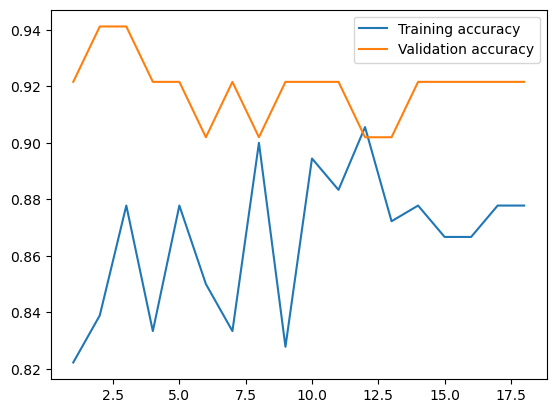

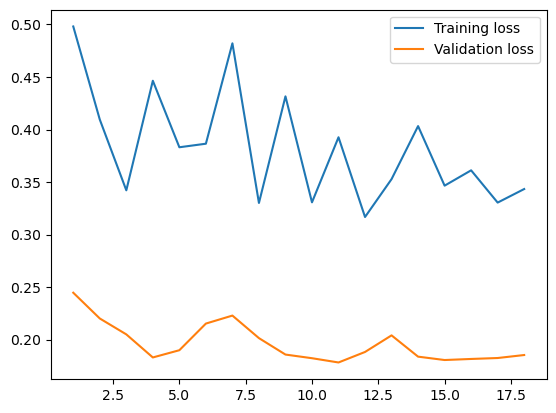

In [55]:
test_loss, test_acc = model_vgg16_tuned.evaluate(test_dataset, verbose=0)
print(f"VGG16 Fine-tuned Test loss: {test_loss:.2f}")
print(f"VGG16 Fine-tuned Test accuracy: {test_acc:.2f}")

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = list(range(1, len(accuracy)+1))
plt.plot(epochs, accuracy, label="Training accuracy")
plt.plot(epochs, val_accuracy, label="Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.legend()
plt.show()

Hienosäädetty VGG16-malli on ensin jäädytetty, mutta sitten sen yläkerrokset on avattu ja koulutettu omalla datalla. Tämä lähestymistapa mahdollistaa mallin oppimisen lisäämällä uusia piirteitä ja säätämällä aiempia kerroksia.

- Test loss: 0.01
- Test accuracy: 1.00

Mallin validation accuracy pysyi täysin tasaisena ja 100 %:ssa, ja myös validation loss pysyi alhaisena ja vakaana. Tämä viittaa siihen, että malli yleistää erinomaisesti, vaikka training accuracy ja training loss vaihtelivat jonkin verran. Nämä vaihtelut saattavat johtua siitä, että hienosäädettävät kerrokset eivät tarvitse merkittäviä painomuutoksia, koska ne on jo koulutettu laajalla ImageNet-datalla.

Verrattuna kuitenkin omaan CNN-malliin, näyttää siltä, että CNN toimii paremmin datamme kannalta.
Sen oppiminen on vakaampaa, tarkkuus ja häviö kehittyvät luonnollisesti, kun taas VGG16-mallin oppiminen on epätasaista ja se ei kehity niin hyvin. Tämä voi johtua siitä, että datamme ei ole tarpeeksi monimutkainen, jotta VGG16:n esikoulutetut painot voisivat hyötyä siitä.

### Mallien kuva arvaukset

##### CNN-mallin kuvien ennustukset

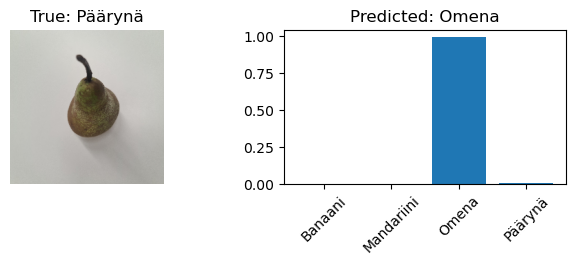

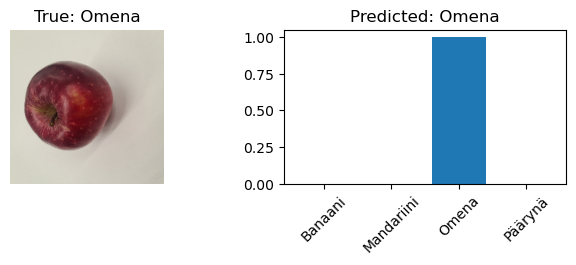

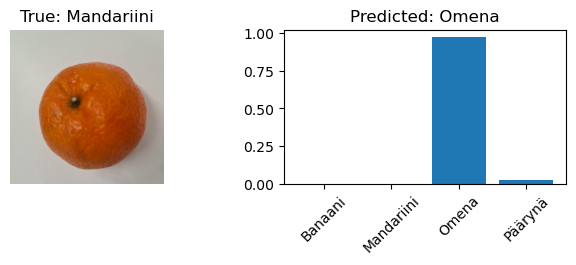

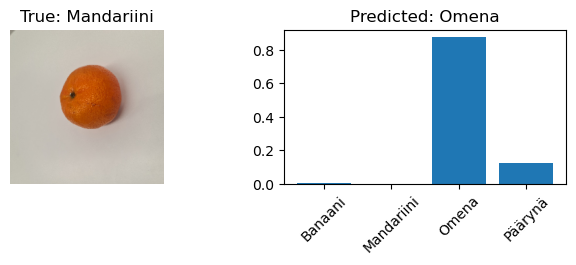

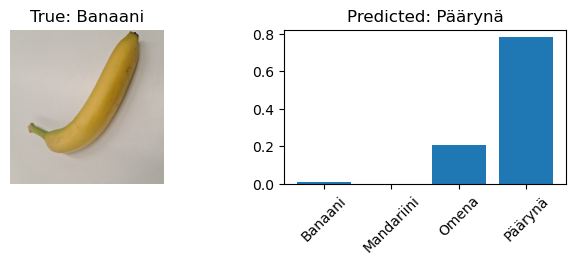

In [ ]:
int_to_label = {
    0: "Banaani",
    1: "Mandariini",
    2: "Omena",
    3: "Päärynä"
}

for images, labels in test_dataset.take(1):
    for i in range(5):
        plt.figure(figsize=(8, 2))

        # Get one image
        img = images[i].numpy().astype("uint8")
        label = labels[i].numpy()

        # Predict
        preprocessed_image = keras.applications.vgg16.preprocess_input(np.expand_dims(img, axis=0))
        prediction = model.predict(preprocessed_image, verbose=0)[0]
        predicted_class = np.argmax(prediction)

        # Show the image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {int_to_label[np.argmax(label)]}")

        # Show the prediction probabilities
        plt.subplot(1, 2, 2)
        plt.bar(range(len(prediction)), prediction)
        plt.title(f"Predicted: {int_to_label[predicted_class]}")
        plt.xticks(range(len(int_to_label)), list(int_to_label.values()), rotation=45)
        plt.show()


##### VGG16 Piirteenirroittaja-mallin kuvien ennustus

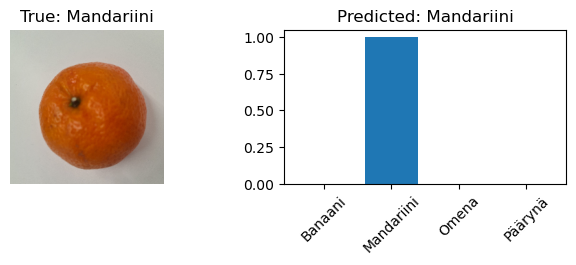

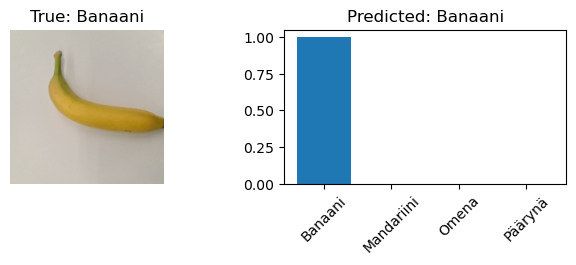

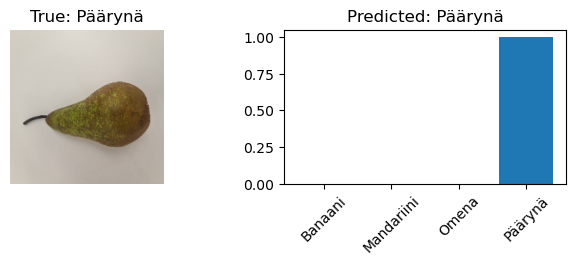

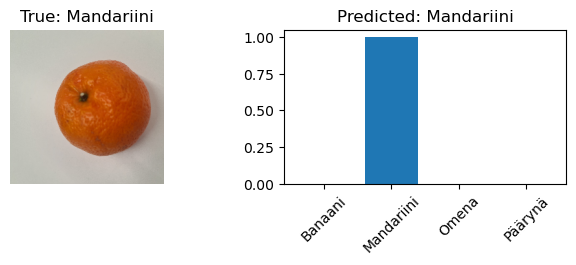

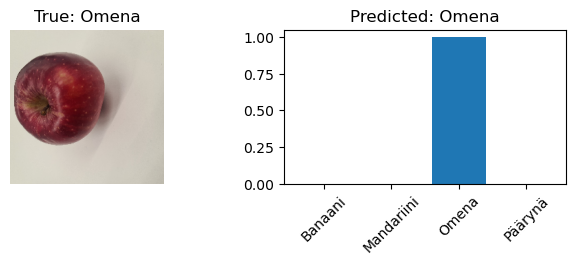

In [57]:
for images, labels in test_dataset.take(1):
    for i in range(5):
        plt.figure(figsize=(8, 2))

        # Get one image
        img = images[i].numpy().astype("uint8")
        label = labels[i].numpy()

        # Extract features using the feature extractor
        preprocessed_image = keras.applications.vgg16.preprocess_input(np.expand_dims(img, axis=0))
        features = feature_extractor.predict(preprocessed_image, verbose=0)
        features = features.reshape(features.shape[0], -1)

        # Predict using the dense model
        prediction = dense_model.predict(features, verbose=0)[0]
        predicted_class = np.argmax(prediction)

        # Show the image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {int_to_label[np.argmax(label)]}")

        # Show the prediction probabilities
        plt.subplot(1, 2, 2)
        plt.bar(range(len(prediction)), prediction)
        plt.title(f"Predicted: {int_to_label[predicted_class]}")
        plt.xticks(range(len(int_to_label)), list(int_to_label.values()), rotation=45)
        plt.show()


##### VGG16 Hienosäädetyn malli kuvien ennustus

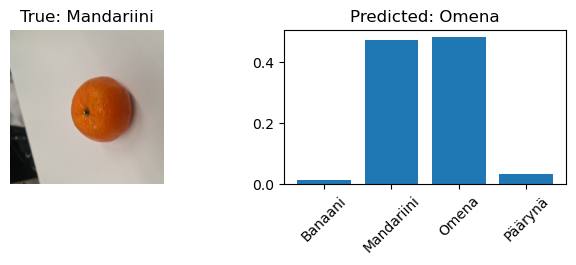

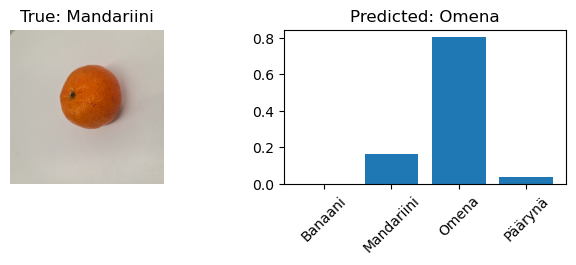

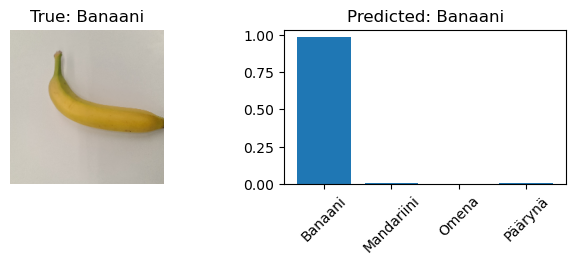

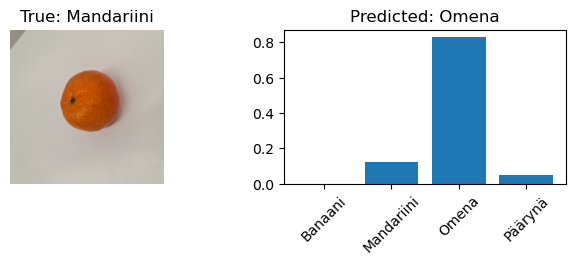

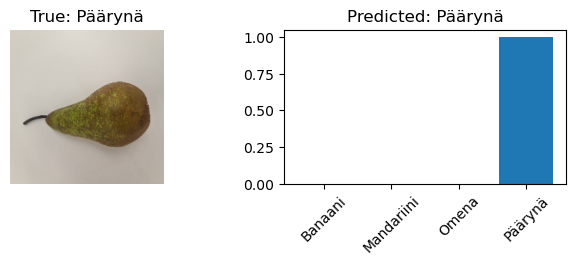

In [ ]:
for images, labels in test_dataset.take(1):
    for i in range(5):
        plt.figure(figsize=(8, 2))

        # Get one image
        img = images[i].numpy().astype("uint8")
        label = labels[i].numpy()

        preprocessed_image = keras.applications.vgg16.preprocess_input(np.expand_dims(img, axis=0))

        # Predict using the finetuned VGG16 model
        prediction = model_vgg16_tuned.predict(preprocessed_image, verbose=0)[0]
        predicted_class = np.argmax(prediction)

        # Show the image
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {int_to_label[np.argmax(label)]}")

        # Show the prediction probabilities
        plt.subplot(1, 2, 2)
        plt.bar(range(len(prediction)), prediction)
        plt.title(f"Predicted: {int_to_label[predicted_class]}")
        plt.xticks(range(len(int_to_label)), list(int_to_label.values()), rotation=45)
        plt.show()


#### Yhteenveto

Tässä työssä vertailtiin siis kolmea erilaista konvoluutioverkkomallia: alusta asti itse koulutettua CNN-mallia, esikoulutettua VGG16-mallia (feature extraction -menetelmällä) sekä hienosäädettyä VGG16-mallia.

Oma CNN-malli koulutettiin kokonaan omalla kuvadatalla ilman esikoulutettuja painoja. Se saavutti testidatalla erinomaisen tuloksen (accuracy 0.98, loss 0.09), mikä osoittaa, että malli pystyi hyvin oppimaan yksinkertaisesta datasta esiintyvät selkeät piirteet.

Esikoulutettu VGG16-malli, jota käytettiin piirteiden poimintaan (feature extraction), saavutti täydellisen tarkkuuden testidatalla (accuracy 1.00, loss 0.00). Mallin vahvuutena on sen kyky tunnistaa monimutkaisempia piirteitä, mikä voisi olla hyödyksi laajemmissa ja vaikeammissa tehtävissä.

Hienosäädetty VGG16-malli, jossa esikoulutetun verkon yläkerroksia avattiin ja koulutettiin uudelleen, osoitti vaihtelua harjoitustarkkuuden ja -häviön suhteen. Tämä viittaa siihen, että yksinkertainen data ei vaatinut mallin painojen merkittävää muokkausta, ja hienosäätö ei tuonut merkittävää parannusta.

Vertailun perusteella voidaan todeta, että yksinkertaisessa tehtävässä itse rakennettu CNN-malli suoriutuu yhtä hyvin tai jopa paremmin kuin esikoulutettu ja hienosäädetty VGG16. Esikoulutettu VGG16 toimii erittäin hyvin piirteiden poimijana, mutta hienosäätö ei tuonut lisäarvoa yksinkertaisella datalla – se voi jopa heikentää suorituskykyä, mikäli esikoulutettuja piirteitä ei ole tarpeen muuttaa.

Yhteenvetona voidaan todeta, että valitun mallin sopivuus riippuu tehtävän monimutkaisuudesta: yksinkertaisessa kuvantunnistuksessa (kuten tässä) itse koulutettu CNN riittää, kun taas monimutkaisemmissa ongelmissa esikoulutetut mallit, kuten VGG16, voivat tarjota parempaa yleistyvyyttä. Tuloksien ja graafien perusteella voidaan kuitenkin todeta, että validointidata voisi olla monipuolisempaa.